In [1]:
import pandas as pd
import sys
sys.path.append('../supercenter-product-recommender')  # Adjust the path as necessary
from db_utilities import read_table
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [2]:
df = read_table('processed_orders_data')
df.head()

,row_id,order_id,product_id,cart_inclusion_order,reordered,product_name,aisle_id,department_id,department,aisle
0,0,1,49302,1,1,EL YOGUR DE BULGARIA,120,16,HUEVOS Y LÁCTEOS,YOGUR
1,1,1,11109,2,1,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...,108,16,HUEVOS Y LÁCTEOS,OTROS QUESOS CREMAS
2,2,1,10246,3,0,CORAZONES DE APIO ORGÁNICOS,83,4,FRUTAS Y VERDURAS,VEGETALES FRESCOS
3,3,1,49683,4,0,KIRBY PEPINO,83,4,FRUTAS Y VERDURAS,VEGETALES FRESCOS
4,4,1,43633,5,1,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...,95,15,PRODUCTOS ENLATADOS,MARISCOS CARNE ENLATADA


# Product Level Association Analysis

In [3]:
sample_size = 10000  # Change this to the desired sample size

# Get a unique list of order_ids
unique_orders = df['order_id'].unique()

# Randomly sample order_ids
sampled_orders = pd.Series(unique_orders).sample(n=sample_size, random_state=42).values

# Step 2: Filter the DataFrame to include only the rows with the selected order_ids
subsampled_data = df[df['order_id'].isin(sampled_orders)]

In [4]:
basket = (subsampled_data\
          .groupby(['order_id', 'product_name'])['product_name']\
          .count().unstack().reset_index().fillna(0)\
          .set_index('order_id'))

# Convert values to binary
basket = basket.map(lambda x: 1 if x > 0 else 0)

# Check the basket matrix
print(f"Basket shape: {basket.shape}")
print(f"Total number of item occurrences: {basket.sum().sum()}")

Basket shape: (10000, 16958)
Total number of item occurrences: 105709


In [5]:
# Apply Apriori Algorithm with a lower minimum support
frequent_itemsets = apriori(basket, min_support=0.005, use_colnames=True)

# Generate Association Rules with a minimum threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the resulting rules
print(f"Number of rules generated: {len(rules)}")
print(rules.head())

/Users/diegoleon/Documents/DLR/Madrid/IE/3rd Term/Capstone Project/supercenter-product-recommender/venv/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Number of rules generated: 278
                  antecedents                 consequents  antecedent support  \
0                    (BANANA)  (100% PAN DE TRIGO ENTERO)              0.1445   
1  (100% PAN DE TRIGO ENTERO)                    (BANANA)              0.0172   
2         (AGUACATE ORGÁNICO)              (AJO ORGÁNICO)              0.0527   
3              (AJO ORGÁNICO)         (AGUACATE ORGÁNICO)              0.0352   
4                    (BANANA)         (AGUACATE ORGÁNICO)              0.1445   

   consequent support  support  confidence      lift  leverage  conviction  \
0              0.0172   0.0053    0.036678  2.132454  0.002815    1.020220   
1              0.1445   0.0053    0.308140  2.132454  0.002815    1.236521   
2              0.0352   0.0054    0.102467  2.910988  0.003545    1.074946   
3              0.0527   0.0054    0.153409  2.910988  0.003545    1.118958   
4              0.0527   0.0173    0.119723  2.271787  0.009685    1.076139   

   zhangs_met

# Aisle Level Association Analysis

In [3]:
basket = (df\
          .groupby(['order_id', 'aisle_id'])['aisle_id']\
          .count().unstack().reset_index().fillna(0)\
          .set_index('order_id'))

# Convert values to binary
basket = basket.map(lambda x: 1 if x > 0 else 0).astype(bool)

# Check the basket matrix
print(f"Basket shape: {basket.shape}")
print(f"Total number of item occurrences: {basket.sum().sum()}")

Basket shape: (131209, 135)
Total number of item occurrences: 998645


In [4]:
# Apply Apriori Algorithm with a lower minimum support
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate Association Rules with a minimum threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the resulting rules
print(f"Number of rules generated: {len(rules)}")

Number of rules generated: 28308


In [8]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(24),(1),0.539468,0.019900,0.012331,0.022859,1.148699,0.001596,1.003028,0.281088
1,(1),(24),0.019900,0.539468,0.012331,0.619686,1.148699,0.001596,1.210927,0.132078
2,(83),(1),0.450541,0.019900,0.010022,0.022245,1.117853,0.001057,1.002399,0.191876
3,(1),(83),0.019900,0.450541,0.010022,0.503638,1.117853,0.001057,1.106974,0.107569
4,(107),(100),0.174325,0.052679,0.012156,0.069733,1.323724,0.002973,1.018332,0.296189
...,...,...,...,...,...,...,...,...,...,...
28303,(84),"(123, 24, 120, 83, 86)",0.223742,0.022902,0.010358,0.046292,2.021282,0.005233,1.024525,0.650898
28304,(24),"(123, 84, 120, 83, 86)",0.539468,0.011303,0.010358,0.019200,1.698685,0.004260,1.008052,0.893117
28305,(120),"(123, 84, 24, 83, 86)",0.253367,0.018680,0.010358,0.040880,2.188399,0.005625,1.023146,0.727325
28306,(83),"(123, 84, 24, 120, 86)",0.450541,0.012987,0.010358,0.022989,1.770173,0.004506,1.010238,0.791840


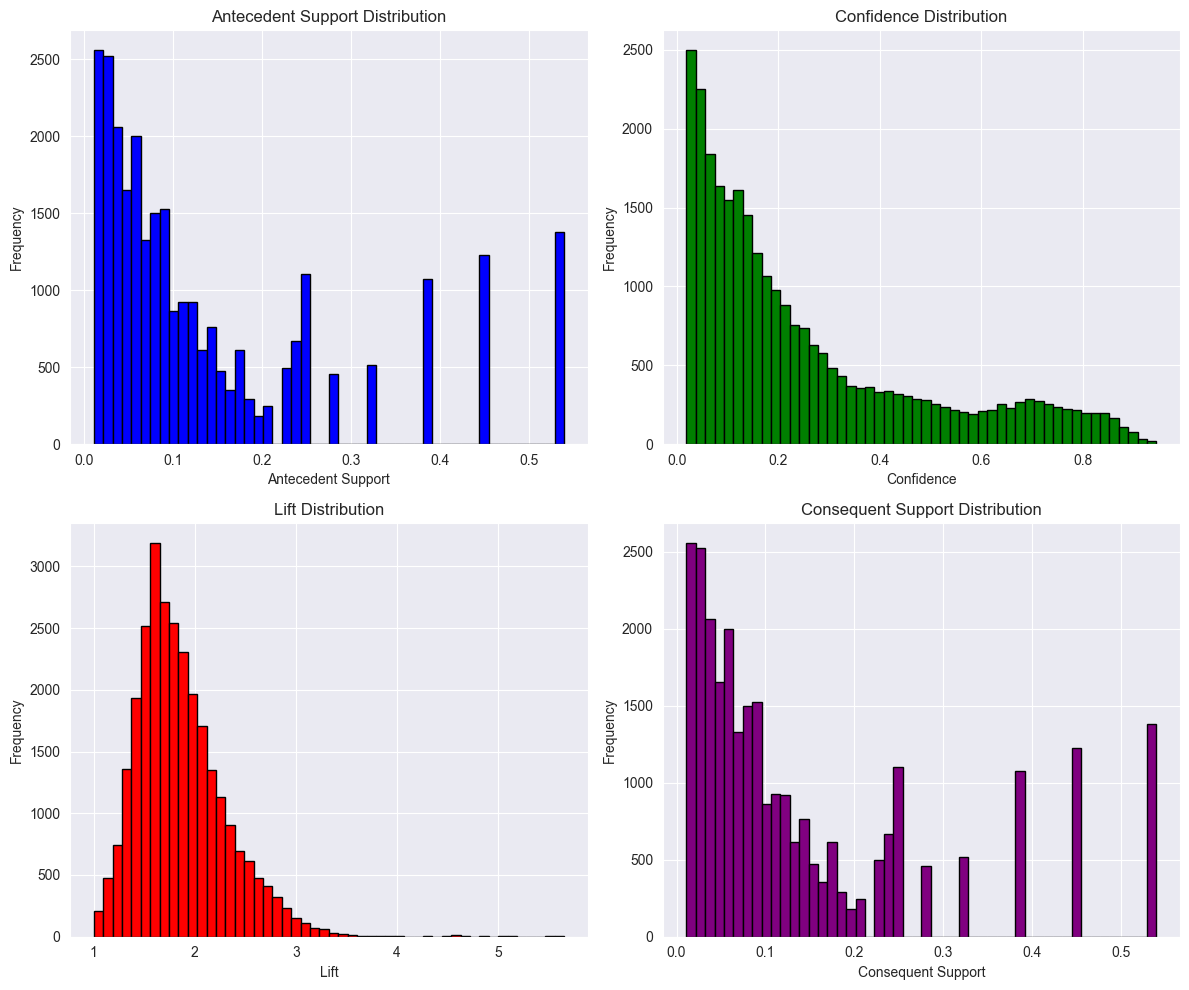

In [5]:
import matplotlib.pyplot as plt

# Plot distributions of support, confidence, lift, and consequent support
plt.figure(figsize=(12, 10))

# Plot Antecedent Support Distribution
plt.subplot(2, 2, 1)
plt.hist(rules['antecedent support'], bins=50, color='blue', edgecolor='black')
plt.title('Antecedent Support Distribution')
plt.xlabel('Antecedent Support')
plt.ylabel('Frequency')

# Plot Confidence Distribution
plt.subplot(2, 2, 2)
plt.hist(rules['confidence'], bins=50, color='green', edgecolor='black')
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Plot Lift Distribution
plt.subplot(2, 2, 3)
plt.hist(rules['lift'], bins=50, color='red', edgecolor='black')
plt.title('Lift Distribution')
plt.xlabel('Lift')
plt.ylabel('Frequency')

# Plot Consequent Support Distribution
plt.subplot(2, 2, 4)
plt.hist(rules['consequent support'], bins=50, color='purple', edgecolor='black')
plt.title('Consequent Support Distribution')
plt.xlabel('Consequent Support')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
rules.shape

(28308, 10)

In [6]:
#Filter out rows with 'Missing' aisles
rules_wo_missing_aisles = rules[
    (~rules['antecedents'].apply(lambda x: 'Missing' in x)) &
    (~rules['consequents'].apply(lambda x: 'Missing' in x))
]

# Define a function to calculate physical distance
def physical_distance(set1, set2):
    set1 = set(map(int, set1))  # Convert elements to integers
    set2 = set(map(int, set2))  # Convert elements to integers
    return max(abs(a - b) for a in set1 for b in set2)

# Calculate the physical distance between antecedents and consequents aisles
rules_wo_missing_aisles['aisle_distance'] = rules_wo_missing_aisles.apply(lambda row: physical_distance(row['antecedents'], row['consequents']), axis=1)



/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_71679/474835474.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_wo_missing_aisles['aisle_distance'] = rules_wo_missing_aisles.apply(lambda row: physical_distance(row['antecedents'], row['consequents']), axis=1)


In [12]:
rules_wo_missing_aisles.shape

(26886, 11)

In [13]:
rules_wo_missing_aisles

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance
0,(24),(1),0.539468,0.019900,0.012331,0.022859,1.148699,0.001596,1.003028,0.281088,23
1,(1),(24),0.019900,0.539468,0.012331,0.619686,1.148699,0.001596,1.210927,0.132078,23
2,(83),(1),0.450541,0.019900,0.010022,0.022245,1.117853,0.001057,1.002399,0.191876,82
3,(1),(83),0.019900,0.450541,0.010022,0.503638,1.117853,0.001057,1.106974,0.107569,82
4,(107),(100),0.174325,0.052679,0.012156,0.069733,1.323724,0.002973,1.018332,0.296189,7
...,...,...,...,...,...,...,...,...,...,...,...
28303,(84),"(123, 24, 120, 83, 86)",0.223742,0.022902,0.010358,0.046292,2.021282,0.005233,1.024525,0.650898,60
28304,(24),"(123, 84, 120, 83, 86)",0.539468,0.011303,0.010358,0.019200,1.698685,0.004260,1.008052,0.893117,99
28305,(120),"(123, 84, 24, 83, 86)",0.253367,0.018680,0.010358,0.040880,2.188399,0.005625,1.023146,0.727325,96
28306,(83),"(123, 84, 24, 120, 86)",0.450541,0.012987,0.010358,0.022989,1.770173,0.004506,1.010238,0.791840,59


In [7]:
# Set initial thresholds based on the distributions
antecedent_support_threshold = 0.05
consequent_support_max_threshold = 0.05
lift_threshold = 1.3

# Filter rules based on the defined thresholds
filtered_rules = rules_wo_missing_aisles[
    (rules_wo_missing_aisles['antecedent support'] >= antecedent_support_threshold) &
    (rules_wo_missing_aisles['consequent support'] <= consequent_support_max_threshold) &
    (rules_wo_missing_aisles['lift'] >= lift_threshold)
]

# Display the filtered rules
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance
60,(21),(105),0.236699,0.030349,0.011844,0.050037,1.648746,0.004660,1.020726,0.515496,84
66,(84),(105),0.223742,0.030349,0.010083,0.045066,1.484946,0.003293,1.015412,0.420704,21
105,(106),(43),0.086297,0.035234,0.010228,0.118520,3.363804,0.007187,1.094484,0.769088,63
159,(107),(130),0.174325,0.044189,0.010403,0.059677,1.350501,0.002700,1.016471,0.314330,23
171,(107),(23),0.174325,0.047085,0.016180,0.092817,1.971254,0.007972,1.050411,0.596734,84
...,...,...,...,...,...,...,...,...,...,...,...
28303,(24),"(84, 123, 86, 83, 120)",0.539468,0.011303,0.010358,0.019200,1.698685,0.004260,1.008052,0.893117,99
28304,(123),"(84, 24, 86, 83, 120)",0.382039,0.013810,0.010358,0.027111,1.963149,0.005082,1.013672,0.793925,99
28305,(86),"(84, 24, 123, 83, 120)",0.147048,0.033367,0.010358,0.070436,2.110985,0.005451,1.039879,0.617019,62
28306,(83),"(84, 24, 123, 86, 120)",0.450541,0.012987,0.010358,0.022989,1.770173,0.004506,1.010238,0.791840,59


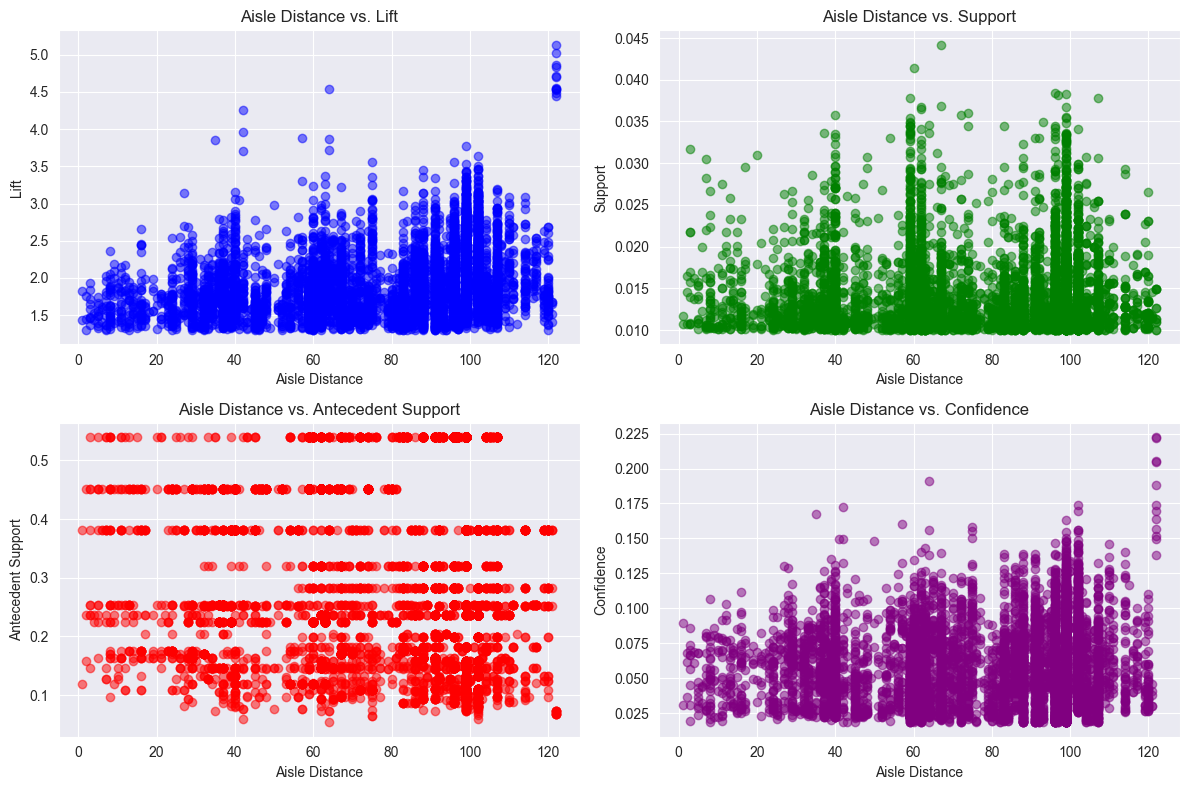

In [8]:
import matplotlib.pyplot as plt

# Scatter plot of Aisle Distance vs. Lift
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(filtered_rules['aisle_distance'], filtered_rules['lift'], alpha=0.5, color='blue')
plt.title('Aisle Distance vs. Lift')
plt.xlabel('Aisle Distance')
plt.ylabel('Lift')

# Scatter plot of Aisle Distance vs. Support
plt.subplot(2, 2, 2)
plt.scatter(filtered_rules['aisle_distance'], filtered_rules['support'], alpha=0.5, color='green')
plt.title('Aisle Distance vs. Support')
plt.xlabel('Aisle Distance')
plt.ylabel('Support')

# Scatter plot of Aisle Distance vs. Antecedent Support
plt.subplot(2, 2, 3)
plt.scatter(filtered_rules['aisle_distance'], filtered_rules['antecedent support'], alpha=0.5, color='red')
plt.title('Aisle Distance vs. Antecedent Support')
plt.xlabel('Aisle Distance')
plt.ylabel('Antecedent Support')

# Scatter plot of Aisle Distance vs. Consequent Support
plt.subplot(2, 2, 4)
plt.scatter(filtered_rules['aisle_distance'], filtered_rules['confidence'], alpha=0.5, color='purple')
plt.title('Aisle Distance vs. Confidence')
plt.xlabel('Aisle Distance')
plt.ylabel('Confidence')

plt.tight_layout()
plt.show()

In [54]:
filtered_rules_business_rules = filtered_rules[(filtered_rules['aisle_distance'] >= 80)]
filtered_rules_business_rules = filtered_rules_business_rules[
    (~filtered_rules_business_rules['antecedents'].apply(lambda x: '24' in x)) &\
     (~filtered_rules_business_rules['antecedents'].apply(lambda x: '83' in x)) &\
      (~filtered_rules_business_rules['antecedents'].apply(lambda x: '123' in x)) &\
       (~filtered_rules_business_rules['consequents'].apply(lambda x: '24' in x)) &\
        (~filtered_rules_business_rules['consequents'].apply(lambda x: '83' in x)) &\
         (~filtered_rules_business_rules['consequents'].apply(lambda x: '123' in x))
]
filtered_rules_business_rules.shape

(177, 11)

In [55]:
filtered_rules_business_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance
60,(21),(105),0.236699,0.030349,0.011844,0.050037,1.648746,0.004660,1.020726,0.515496,84
171,(107),(23),0.174325,0.047085,0.016180,0.092817,1.971254,0.007972,1.050411,0.596734,84
312,(21),(110),0.236699,0.032955,0.013932,0.058860,1.786054,0.006132,1.027525,0.576583,89
431,(115),(23),0.204734,0.047085,0.013231,0.064624,1.372496,0.003591,1.018751,0.341270,92
620,(120),(14),0.253367,0.031758,0.011478,0.045301,1.426434,0.003431,1.014186,0.400399,106
...,...,...,...,...,...,...,...,...,...,...,...
17062,(21),"(84, 120, 86)",0.236699,0.022346,0.010579,0.044692,1.999998,0.005289,1.023391,0.655049,99
17068,"(84, 120)","(96, 21)",0.086976,0.049593,0.010365,0.119173,2.403034,0.006052,1.078994,0.639479,99
17069,"(84, 21)","(96, 120)",0.076092,0.041377,0.010365,0.136218,3.292139,0.007217,1.109798,0.753588,99
17075,(120),"(84, 21, 96)",0.253367,0.019160,0.010365,0.040910,2.135128,0.005511,1.022677,0.712055,99


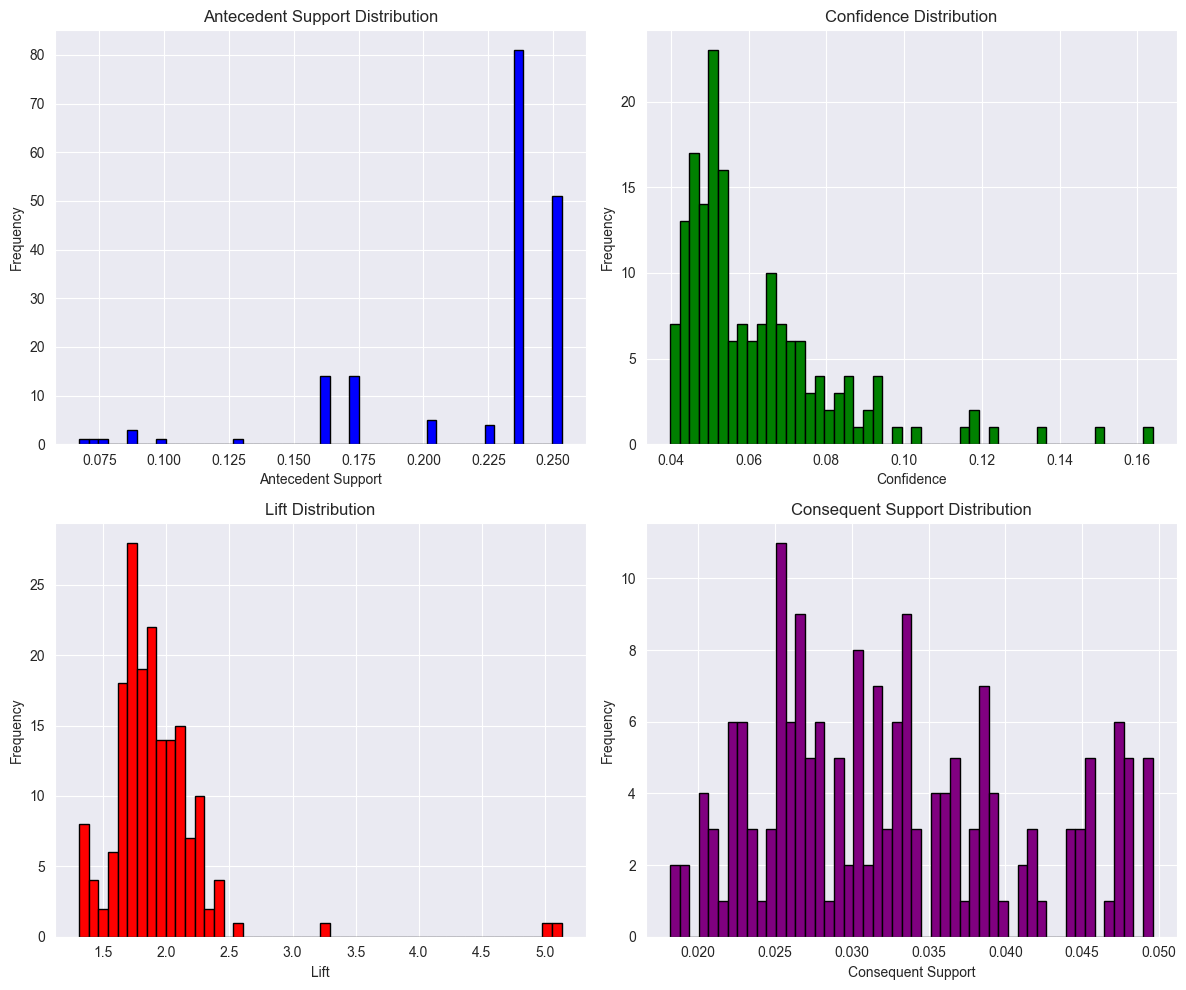

In [56]:
# Plot distributions of support, confidence, lift, and consequent support
plt.figure(figsize=(12, 10))

# Plot Antecedent Support Distribution
plt.subplot(2, 2, 1)
plt.hist(filtered_rules_business_rules['antecedent support'], bins=50, color='blue', edgecolor='black')
plt.title('Antecedent Support Distribution')
plt.xlabel('Antecedent Support')
plt.ylabel('Frequency')

# Plot Confidence Distribution
plt.subplot(2, 2, 2)
plt.hist(filtered_rules_business_rules['confidence'], bins=50, color='green', edgecolor='black')
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Plot Lift Distribution
plt.subplot(2, 2, 3)
plt.hist(filtered_rules_business_rules['lift'], bins=50, color='red', edgecolor='black')
plt.title('Lift Distribution')
plt.xlabel('Lift')
plt.ylabel('Frequency')

# Plot Consequent Support Distribution
plt.subplot(2, 2, 4)
plt.hist(filtered_rules_business_rules['consequent support'], bins=50, color='purple', edgecolor='black')
plt.title('Consequent Support Distribution')
plt.xlabel('Consequent Support')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [57]:
filtered_rules_business_rules['combined_score'] = filtered_rules_business_rules['lift'] * filtered_rules_business_rules['antecedent support']

filtered_rules_business_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance,combined_score
60,(21),(105),0.236699,0.030349,0.011844,0.050037,1.648746,0.004660,1.020726,0.515496,84,0.390256
171,(107),(23),0.174325,0.047085,0.016180,0.092817,1.971254,0.007972,1.050411,0.596734,84,0.343639
312,(21),(110),0.236699,0.032955,0.013932,0.058860,1.786054,0.006132,1.027525,0.576583,89,0.422757
431,(115),(23),0.204734,0.047085,0.013231,0.064624,1.372496,0.003591,1.018751,0.341270,92,0.280997
620,(120),(14),0.253367,0.031758,0.011478,0.045301,1.426434,0.003431,1.014186,0.400399,106,0.361411
...,...,...,...,...,...,...,...,...,...,...,...,...
17062,(21),"(84, 120, 86)",0.236699,0.022346,0.010579,0.044692,1.999998,0.005289,1.023391,0.655049,99,0.473397
17068,"(84, 120)","(96, 21)",0.086976,0.049593,0.010365,0.119173,2.403034,0.006052,1.078994,0.639479,99,0.209006
17069,"(84, 21)","(96, 120)",0.076092,0.041377,0.010365,0.136218,3.292139,0.007217,1.109798,0.753588,99,0.250507
17075,(120),"(84, 21, 96)",0.253367,0.019160,0.010365,0.040910,2.135128,0.005511,1.022677,0.712055,99,0.540971


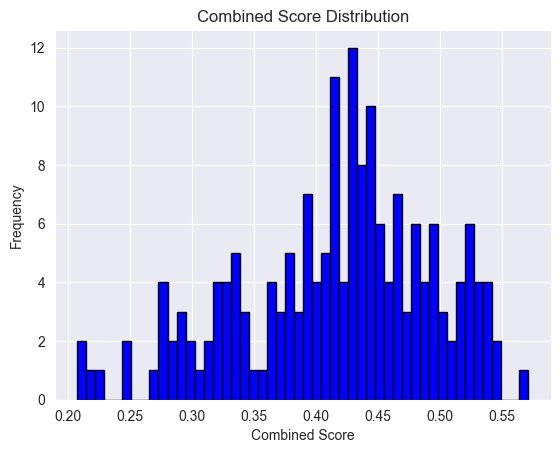

In [58]:
plt.hist(filtered_rules_business_rules['combined_score'], bins=50, color='blue', edgecolor='black')
plt.title('Combined Score Distribution')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.show()

In [60]:
sorted_rules = filtered_rules_business_rules.sort_values(by='combined_score', ascending=False)

top_percentage = 0.1  # Select top 5% of the rules
num_top_rules = int(len(sorted_rules) * top_percentage)
top_rules = sorted_rules.head(num_top_rules)

# Display the number of rules selected
print(f"Number of rules selected: {num_top_rules}")
top_rules

Number of rules selected: 17


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance,combined_score
17076,(21),"(84, 120, 96)",0.236699,0.018154,0.010365,0.043790,2.412133,0.006068,1.026810,0.766970,99,0.570949
7998,(21),"(84, 128)",0.236699,0.018650,0.010205,0.043114,2.311803,0.005791,1.025567,0.743399,107,0.547201
2110,(21),"(96, 106)",0.236699,0.018901,0.010281,0.043436,2.298076,0.005807,1.025649,0.740014,85,0.543952
17075,(120),"(84, 21, 96)",0.253367,0.019160,0.010365,0.040910,2.135128,0.005511,1.022677,0.712055,99,0.540971
3131,(21),"(108, 112)",0.236699,0.022895,0.012316,0.052033,2.272718,0.006897,1.030738,0.733653,91,0.537949
6160,(120),"(84, 3)",0.253367,0.023870,0.012827,0.050626,2.120863,0.006779,1.028182,0.707836,117,0.537356
5654,(21),"(120, 128)",0.236699,0.022209,0.011912,0.050327,2.266071,0.006655,1.029608,0.731962,107,0.536376
2193,(21),"(108, 107)",0.236699,0.023390,0.012484,0.052742,2.254868,0.006947,1.030986,0.729090,87,0.533724
3276,(21),"(86, 108)",0.236699,0.020608,0.010990,0.046431,2.253008,0.006112,1.027080,0.728610,87,0.533284
3870,(21),"(96, 112)",0.236699,0.035653,0.018924,0.079950,2.242439,0.010485,1.048146,0.725869,91,0.530782


In [71]:
top_rules['antecedents'].unique()

array([frozenset({'21'}), frozenset({'120'})], dtype=object)

In [40]:
aisles_df = pd.read_excel('../data/raw/tabla_pasillos.xlsx')
aisles_df.dtypes

id_pasillo     int64
pasillo       object
dtype: object

In [73]:
aisles_df[(aisles_df['id_pasillo'].isin([84,96,3]))]

,id_pasillo,pasillo
2,3,BARRAS DE GRANOLA DE ENERGÍA
83,84,LECHES
95,96,CARNE DE ALMUERZO


In [66]:
aisles_df[(aisles_df['id_pasillo']==24) |\
    (aisles_df['id_pasillo']==83) |\
    (aisles_df['id_pasillo']==123)]

,id_pasillo,pasillo
23,24,FRUTAS FRESCAS
82,83,VEGETALES FRESCOS
122,123,ENVASADOS ​​DE FRUTAS Y VEGETALES


In [61]:
top_rules.to_csv('top_rules.csv')

/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_71679/1155086346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_rules['antecedent_support_size'] = top_rules['antecedent support'] * 1000  # Scale for better visualization


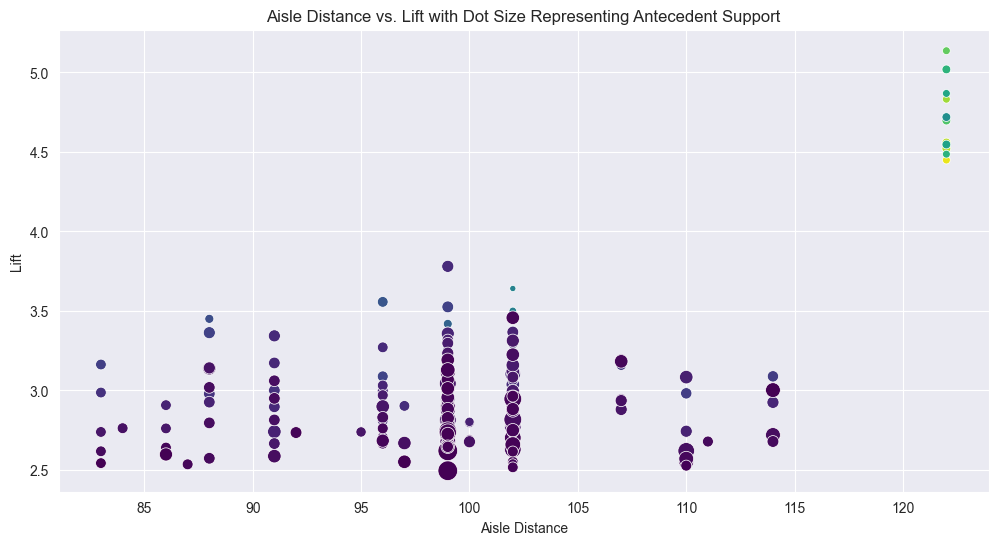

In [18]:
import seaborn as sns
top_rules['antecedent_support_size'] = top_rules['antecedent support'] * 1000  # Scale for better visualization

# Scatter Plot of Aisle Distance vs. Lift with Dot Size as Antecedent Support
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='antecedent_support', 
    y='lift', 
    size='aisle_distance', 
    sizes=(20, 200), 
    hue='combined_score', 
    palette='viridis', 
    data=top_rules, 
    legend=False
)
plt.title('Aisle Distance vs. Lift with Dot Size Representing Antecedent Support')
plt.xlabel('Aisle Distance')
plt.ylabel('Lift')
plt.show()

In [50]:
filtered_rules_aisle_24 = filtered_rules[(filtered_rules['aisle_distance'] >= 80) &\
                                         (filtered_rules['antecedents']\
                                          .apply(lambda x: x == ['24'] or x == {'24'})) &\
                                         (~filtered_rules['consequents']\
                                          .apply(lambda x: '83' in x)) &\
                                         (~filtered_rules['consequents']\
                                          .apply(lambda x: '123' in x))
]

sorted_rules_aisle_24 = filtered_rules_aisle_24.sort_values(by='lift', ascending=False)
N = 10
top_rules_aisle_24 = sorted_rules_aisle_24.head(N)
top_rules_aisle_24

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance
16601,(24),"(120, 16, 21)",0.539468,0.013116,0.011569,0.021446,1.635029,0.004493,1.008512,0.843350,96
14683,(24),"(120, 91, 116)",0.539468,0.014717,0.012751,0.023636,1.606010,0.004811,1.009135,0.819354,96
14669,(24),"(84, 120, 116)",0.539468,0.017720,0.015350,0.028453,1.605725,0.005790,1.011048,0.819114,96
12527,(24),"(120, 116, 112)",0.539468,0.012514,0.010838,0.020090,1.605318,0.004087,1.007730,0.818771,96
5733,(24),"(120, 16)",0.539468,0.030813,0.026431,0.048995,1.590047,0.009808,1.019118,0.805780,96
14627,(24),"(120, 21, 116)",0.539468,0.020067,0.017202,0.031886,1.588969,0.006376,1.012208,0.804853,96
17301,(24),"(84, 67, 120)",0.539468,0.013307,0.011394,0.021121,1.587200,0.004215,1.007982,0.803330,96
15243,(24),"(117, 120, 21)",0.539468,0.012057,0.010281,0.019058,1.580666,0.003777,1.007137,0.797675,96
15033,(24),"(84, 21, 116)",0.539468,0.016013,0.013650,0.025303,1.580171,0.005012,1.009531,0.797245,92
10679,(24),"(84, 120, 106)",0.539468,0.011775,0.010030,0.018592,1.578927,0.003678,1.006946,0.796162,96


In [67]:
aisles_df[(aisles_df['id_pasillo'].isin([120,116,84]))]

,id_pasillo,pasillo
83,84,LECHES
115,116,PRODUCTOS CONGELADOS
119,120,YOGUR


In [52]:
filtered_rules_aisle_83 = filtered_rules[(filtered_rules['aisle_distance'] >= 60) &\
                                         (filtered_rules['antecedents']\
                                          .apply(lambda x: x == ['83'] or x == {'83'})) &\
                                         (~filtered_rules['consequents']\
                                          .apply(lambda x: '24' in x)) &\
                                         (~filtered_rules['consequents']\
                                          .apply(lambda x: '123' in x))
]

sorted_rules_aisle_83 = filtered_rules_aisle_83.sort_values(by='lift', ascending=False)
N = 10
top_rules_aisle_83 = sorted_rules_aisle_83.head(N)
top_rules_aisle_83

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance
8315,(83),"(16, 59)",0.450541,0.014831,0.013635,0.030263,2.040485,0.006953,1.015913,0.928041,67
16612,(83),"(120, 16, 21)",0.450541,0.013116,0.012057,0.026761,2.040288,0.006148,1.014020,0.927954,67
8327,(83),"(16, 69)",0.450541,0.015197,0.013932,0.030923,2.034778,0.007085,1.016227,0.925539,67
20598,(83),"(84, 21, 16)",0.450541,0.010967,0.010037,0.022279,2.031379,0.005096,1.011569,0.924042,67
8333,(83),"(81, 16)",0.450541,0.018772,0.017163,0.038095,2.029411,0.008706,1.020089,0.923173,67
8213,(83),"(16, 19)",0.450541,0.013277,0.012118,0.026897,2.025886,0.006136,1.013997,0.921613,67
8321,(83),"(67, 16)",0.450541,0.011699,0.010647,0.023632,2.020012,0.005376,1.012222,0.919001,67
4971,(83),"(116, 16)",0.450541,0.018901,0.017148,0.038061,2.013709,0.008632,1.019918,0.916181,67
8357,(83),"(96, 16)",0.450541,0.012263,0.011089,0.024613,2.007118,0.005564,1.012662,0.913213,67
8351,(83),"(91, 16)",0.450541,0.022773,0.020563,0.045640,2.004136,0.010303,1.023961,0.911864,67


In [70]:
aisles_df[(aisles_df['id_pasillo']==59)]

,id_pasillo,pasillo
58,59,COMIDAS ENLATADAS JUDÍAS


In [53]:
filtered_rules_aisle_123 = filtered_rules[(filtered_rules['aisle_distance'] >= 80) &\
                                         (filtered_rules['antecedents']\
                                          .apply(lambda x: x == ['123'] or x == {'123'})) &\
                                         (~filtered_rules['consequents']\
                                          .apply(lambda x: '24' in x)) &\
                                         (~filtered_rules['consequents']\
                                          .apply(lambda x: '83' in x))
]

sorted_rules_aisle_123 = filtered_rules_aisle_123.sort_values(by='lift', ascending=False)
N = 10
top_rules_aisle_123 = sorted_rules_aisle_123.head(N)
top_rules_aisle_123

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,aisle_distance
15688,(123),"(67, 120, 21)",0.382039,0.015769,0.011287,0.029545,1.873641,0.005263,1.014196,0.754546,102
4852,(123),"(116, 16)",0.382039,0.018901,0.013398,0.035071,1.855492,0.006177,1.016757,0.746098,107
14555,(123),"(120, 116, 21)",0.382039,0.020067,0.014153,0.037046,1.846090,0.006487,1.017632,0.741657,102
14780,(123),"(84, 21, 116)",0.382039,0.016013,0.011226,0.029385,1.835137,0.005109,1.013778,0.736425,102
6863,(123),"(91, 16)",0.382039,0.022773,0.015761,0.041255,1.811598,0.007061,1.019278,0.724967,107
15744,(123),"(86, 120, 21)",0.382039,0.022567,0.015449,0.040437,1.791873,0.006827,1.018623,0.715134,102
5439,(123),"(120, 16)",0.382039,0.030813,0.021066,0.055140,1.789477,0.009294,1.025746,0.713925,107
15772,(123),"(96, 120, 21)",0.382039,0.021721,0.014847,0.038861,1.789106,0.006548,1.017833,0.713737,102
15758,(123),"(120, 21, 91)",0.382039,0.021592,0.014725,0.038542,1.785059,0.006476,1.017630,0.711687,102
6827,(123),"(21, 16)",0.382039,0.033069,0.022171,0.058033,1.754874,0.009537,1.026501,0.696094,107


In [69]:
aisles_df[(aisles_df['id_pasillo'].isin([21,16]))]

,id_pasillo,pasillo
15,16,HIERBAS FRESCAS
20,21,QUESOS ENVASADOS


In [62]:
top_rules_aisle_24.to_csv('top_rules_aisle_24.csv')
top_rules_aisle_83.to_csv('top_rules_aisle_83.csv')
top_rules_aisle_123.to_csv('top_rules_aisle_123.csv')